## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_predict, cross_val_score
import seaborn as sns

## Get Data from GDrive

In [2]:
!gdown 1Ky1KGnjF8WNAsViTAK83t7jg9EYpyC8r

Downloading...
From: https://drive.google.com/uc?id=1Ky1KGnjF8WNAsViTAK83t7jg9EYpyC8r
To: /content/credit_scoring.csv
100% 260k/260k [00:00<00:00, 77.9MB/s]


## Exploratory Data Analyst

In [3]:
df = pd.read_csv('credit_scoring.csv')

In [4]:
df.head(3)

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
application_id,6000.0,5.039995e+05,1.732195e+03,501000.000,502499.75,503999.5,5.054992e+05,5.069990e+05
age,6000.0,4.032150e+01,1.130070e+01,21.000,31.00,41.0,5.000000e+01,5.900000e+01
monthly_income,6000.0,1.140386e+07,4.912598e+06,3000310.000,7163379.00,11299453.0,1.573705e+07,1.998622e+07
loan_amount,6000.0,8.001122e+06,4.071786e+06,1000794.000,4440939.00,7982303.5,1.153144e+07,1.499858e+07
previous_defaults,6000.0,2.436667e-01,4.847670e-01,0.000,0.00,0.0,0.000000e+00,3.000000e+00
credit_score,6000.0,5.759798e+02,1.583289e+02,300.000,438.75,577.5,7.130000e+02,8.490000e+02
default,6000.0,1.216667e-02,1.096387e-01,0.000,0.00,0.0,0.000000e+00,1.000000e+00
leak_col_good,6000.0,1.216667e-02,1.096387e-01,0.000,0.00,0.0,0.000000e+00,1.000000e+00
leak_col_subtle,6000.0,1.194467e-02,1.139465e-01,-0.119,-0.02,0.0,2.100000e-02,1.092000e+00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [7]:
miss_value = df.isna().sum()
miss_value

,0
application_id,0
age,0
monthly_income,0
loan_amount,0
previous_defaults,0
credit_score,0
default,0
leak_col_good,0
leak_col_subtle,0


Dari info diatas ditiap fitur tidak ada missing value, dan terdapat 2 leakage fitur yang akan didrop nantinya yaitu  leak_col_good dan leak_col_subtle

and since fitur application_id hanya untuk melakukan unique id untuk users, fitur itu juga akan didrop

In [8]:
def plot_outliers(df, col_list):
  n_cols = 4
  n_rows = int(np.ceil(len(col_list) / n_cols))

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))

  # flatten axes for easier iteration
  axes = axes.flatten()

  # outlier plotting using boxplot
  for i, feature in enumerate(col_list):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(feature)

  # remove unused subplots if exists
  for j in range(len(col_list), len(axes)):
    fig.delaxes(axes[j]) # remove empty axes

  plt.tight_layout(pad=2.0)
  plt.show()


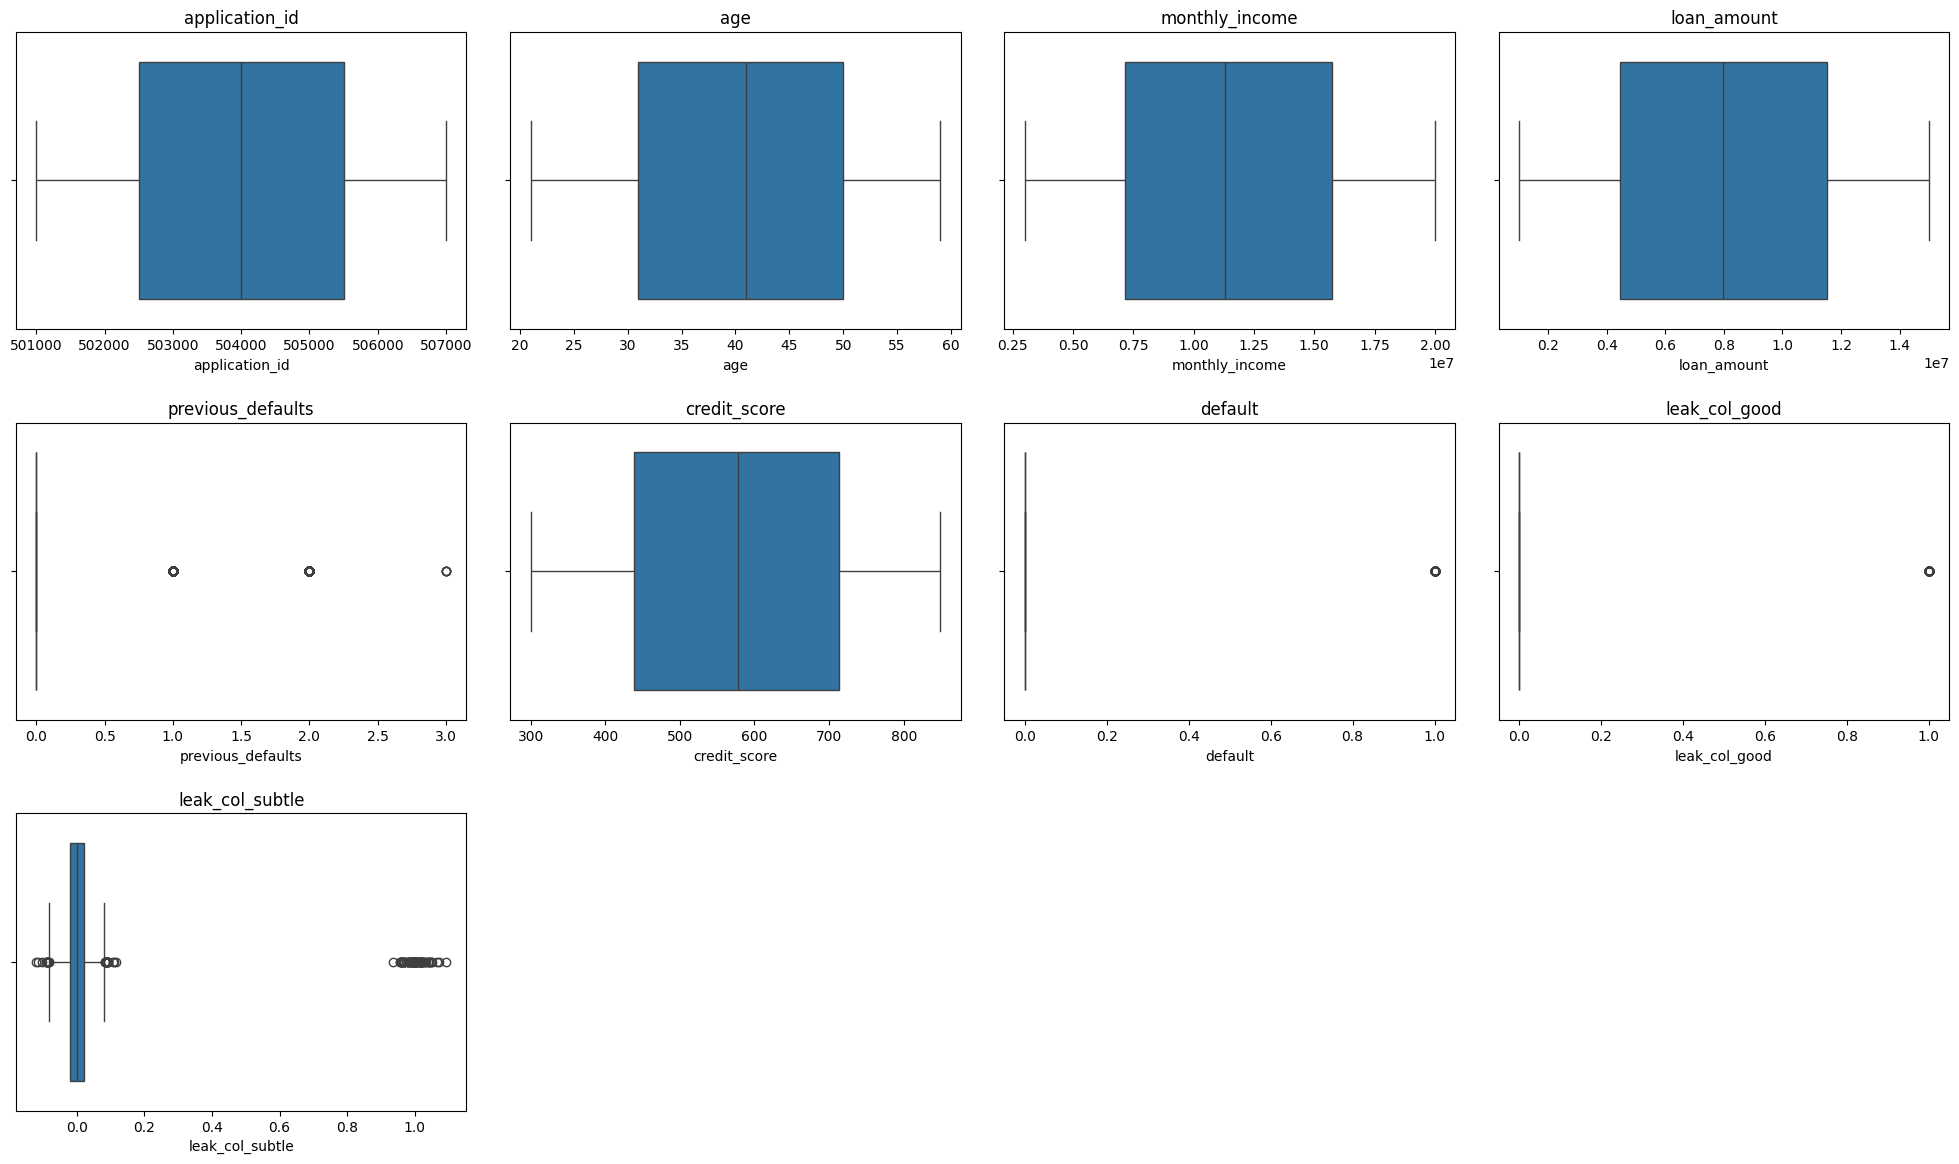

In [9]:
plot_outliers(df, df.columns.tolist())

In [10]:
df.drop(columns=['leak_col_good', 'leak_col_subtle', 'application_id'], inplace=True)

In [11]:
df.head(3)

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,41,13995609,5982664,0,624,0
1,58,13683833,3711198,0,809,0
2,33,9417391,7172332,0,647,0


In [13]:
df['previous_defaults'].unique(), df['default'].unique()

(array([0, 1, 2, 3]), array([0, 1]))

## Modelling

In [16]:
## Split input features and output feature
X = df.drop(columns='default')
y = df['default']

In [17]:
# determine highly correlated features based on threshold
corr_matrix = X.corr()
high_corr_feats = set()
threshold = 0.85

for i in range(len(corr_matrix.columns)):
  # loop through the lower triangle of the correlation matrix to avoid redundancy
  for j in range(i):
    # check if the absolute correlation exceeds the threshold
    if abs(corr_matrix.iloc[i, j]) > threshold:
      col_name = corr_matrix.columns[i] # get the name of the column
      high_corr_feats.add(col_name) # add the column to the set

print(f'Columns with high correlation (> 0.85): {high_corr_feats}')

# drop highly correlated features
X_filtered = X.drop(columns=high_corr_feats)


Columns with high correlation (> 0.85): set()


Tahapan pertama adalah dengan mengidentifikasi dan menghapus fitur dengan korelasi yang tinggi (melebihi ambang batas 0.85). Hal ini dilakukan dengan memanfaatkan method corr() kemudian melakukan iterasi pada segitiga bawah dari matriks korelasi untuk menghindari pemeriksaan yang redundan. Dataset hasil seleksi akan disimpan dalam X_filtered yang akan digunakan untuk proses seleksi lebih lanjut menggunakan RF classifier.

In [18]:
# feature selection using random forest classifier feature importances
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_filtered, y)

# get feature importances
feature_importance = pd.Series(model.feature_importances_, index=X_filtered.columns)

# select top features
top_feats = feature_importance.sort_values(ascending=False).head(12)

# get the names of the selected features
top_feats_name = top_feats.index.tolist()

# display the selected features and its importance score
display(top_feats)


,0
loan_amount,0.294576
monthly_income,0.293470
credit_score,0.241492
age,0.133131
previous_defaults,0.037331


Tahapan ini memanfaatkan feature importances dari Random Forest Classifier untuk mengurutkan fitur berdasarkan pengaruhnya terhadap variabel target.

In [20]:
y.value_counts(normalize=True)

,proportion
default,
0,0.987833
1,0.012167


Terlihat distribusi kelas pada label sangat tidak seimbang, di mana data kelas 0 mencakup hampir 98% dari total data. Hal ini tentunya berpotensi menyebabkan bias pada saat klasifikasi, di mana model cenderung memprediksi kelas mayoritas dibanding kelas minoritas. Untuk itu, dilakukan tahapan resampling, seperti oversampling dengan SMOTE.

In [21]:
## Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [23]:
y_resampled.value_counts(normalize=True)

,proportion
default,
0,0.5
1,0.5


In [24]:
def learning_curve_plot(model, X, y, cv=5):
  # define cross-validation using stratifiedkfold
  cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

  # compute the learning curve
  train_sizes, train_scores, test_scores = learning_curve(
      model, X, y, cv=cv, scoring='accuracy',
      n_jobs=4, train_sizes=np.linspace(0.3, 1.0, 5)
  )

  # calculate the mean and standard deviation
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  # plot the learning curve
  plt.figure(figsize=(8,5))

  plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)

  plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Cross-Validation Accuracy')
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.2)

  plt.xlabel('Training Set Size')
  plt.ylabel('Accuracy')
  plt.title(f'{model.__class__.__name__} Learning Curve')
  plt.legend()
  plt.show()


In [25]:
# function to evaluate training and testing accuracy
def train_test_acc(model, X_train, y_train, X_test, y_test):
  train_acc = model.score(X_train, y_train)
  test_acc = model.score(X_test, y_test)

  print(f'Training accuracy: {train_acc:.3f}')
  print(f'Testing accuracy: {test_acc:.3f}')

In [26]:
# function to display model's evaluation based on metrics, confusion matrix, & classification reports
def evaluate_model(model, X, y, cv=5):
  # model prediction using cross-validation
  y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
  y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

  # confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # classification report
  cr = classification_report(y_test, y_pred)

  # cross-validation metric scores
  accuracy = np.round(np.mean(cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)), 3)
  precision = np.round(np.mean(cross_val_score(model, X, y, cv=cv, scoring='precision', n_jobs=-1)), 3)
  recall = np.round(np.mean(cross_val_score(model, X, y, cv=cv, scoring='recall', n_jobs=-1)), 3)
  f1_score = np.round(np.mean(cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1)), 3)
  roc_auc = np.round(roc_auc_score(y, y_pred_proba), 3)

  # display information
  print(f'==== {model.__class__.__name__} ====')
  print('\nConfusion Matrix')
  print(cm)
  print('\nMetrics Score (Cross-Validated)')
  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1_score}')
  print(f'ROC-AUC: {roc_auc}')
  print('\nClassification Report')
  print(cr)

  # information summary (used for model's performance comparison)
  summary = {
      'Confusion Matrix': cm,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1-Score': {f1_score},
      'ROC-AUC': {roc_auc}
  }

  return summary

In [27]:
# function to visualize confusion matrix using heatmap
def cm_visualization(model, cm, labels):
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, cmap='icefire', cbar=False, fmt='d', xticklabels=labels, yticklabels=labels)

  plt.title(f'{model.__class__.__name__} Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [28]:
# logistic regression model
lr = LogisticRegression(max_iter=1000, random_state=42)

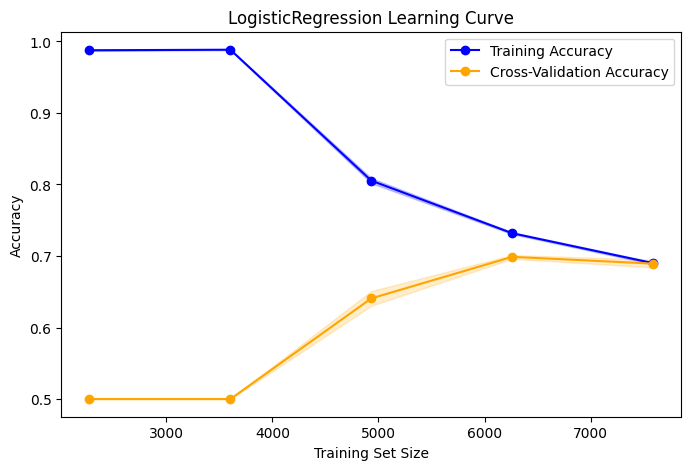

In [29]:
# learning curve
learning_curve_plot(lr, X_resampled, y_resampled)

In [31]:
lr.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [32]:
# model evaluation
lr_result = evaluate_model(lr, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


==== LogisticRegression ====

Confusion Matrix
[[1184    0]
 [  16    0]]

Metrics Score (Cross-Validated)
Accuracy: 0.987
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC-AUC: 0.847

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1184
           1       0.00      0.00      0.00        16

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.97      0.99      0.98      1200



In [33]:
# training and testing accuracy gap
train_test_acc(lr, X_resampled, y_resampled, X_test, y_test)

Training accuracy: 0.690
Testing accuracy: 0.686


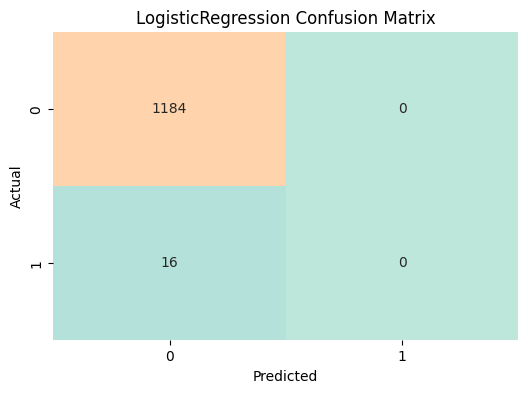

In [34]:
# confusion matrix visualization
cm_visualization(lr, lr_result['Confusion Matrix'], labels=np.unique(y_test))

In [35]:
#Gradient model
lrg = GradientBoostingClassifier(random_state=42)

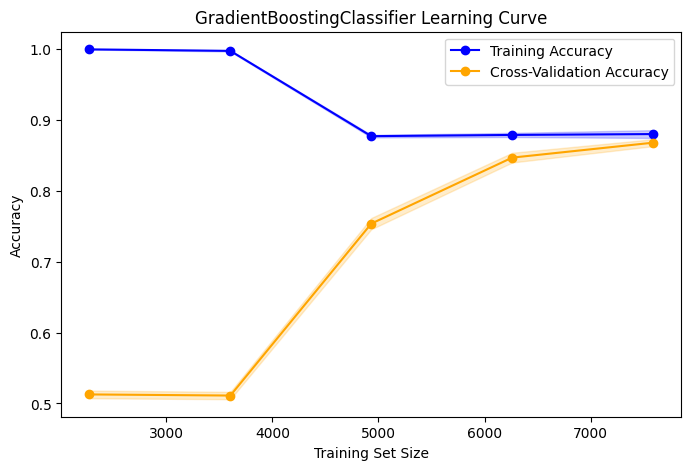

In [36]:
# learning curve
learning_curve_plot(lrg, X_resampled, y_resampled)

In [37]:
lrg.fit(X_resampled, y_resampled)

GradientBoostingClassifier(random_state=42)

In [38]:
# model evaluation
lrg_result = evaluate_model(lrg, X_test, y_test)

==== GradientBoostingClassifier ====

Confusion Matrix
[[1178    6]
 [  16    0]]

Metrics Score (Cross-Validated)
Accuracy: 0.982
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC-AUC: 0.73

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1184
           1       0.00      0.00      0.00        16

    accuracy                           0.98      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.97      0.98      0.98      1200



In [43]:
# training and testing accuracy gap
train_test_acc(lrg, X_resampled, y_resampled, X_test, y_test)

Training accuracy: 0.879
Testing accuracy: 0.812


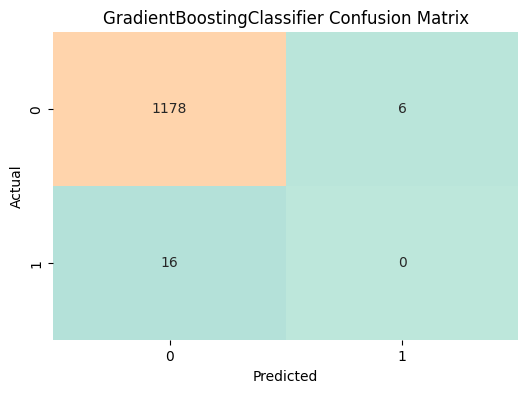

In [40]:
# confusion matrix visualization
cm_visualization(lrg, lrg_result['Confusion Matrix'], labels=np.unique(y_test))

AUC Logistic: 0.7979835304054054
AUC GBM: 0.6433699324324325


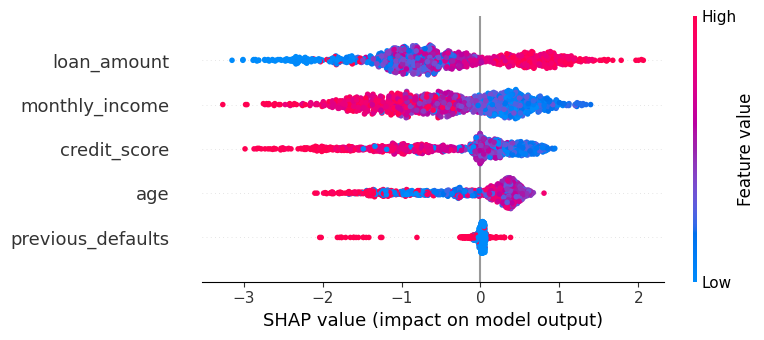

In [41]:
import shap
# Evaluasi AUC
y_pred_log = lr.predict_proba(X_test)[:, 1]
y_pred_gbm = lrg.predict_proba(X_test)[:, 1]
print("AUC Logistic:", roc_auc_score(y_test, y_pred_log))
print("AUC GBM:", roc_auc_score(y_test, y_pred_gbm))

# Fungsi konversi ke skor kredit
A = 600
B = 50 / np.log(2)
def to_score(p):
    odds = (1 - p) / p
    return A + B * np.log(odds)

# Simpan skor ke CSV untuk validasi R
df_score = pd.DataFrame({"actual": y_test, "prob": y_pred_gbm})
df_score["score"] = to_score(df_score["prob"])
df_score.to_csv("prob_test.csv", index=False)

# SHAP analysis
explainer = shap.Explainer(lrg)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("../shap_top10.png")


  *   Loan amount memiliki dampak negatif besar terhadap output model (semakin besar loan, semakin tinggi risiko default).

*   Monthly income juga berkontribusi negatif pada prediksi default — nilai rendah cenderung meningkatkan prediksi default.

*   Credit score bersifat pelindung: semakin tinggi skornya (warna merah), SHAP value-nya mendekati 0 (risiko lebih rendah).


*   Warna pada setiap fitur menunjukkan nilai input (biru = rendah, merah = tinggi).


Sebaran SHAP relatif simetris dan padat, memberi indikasi bahwa model punya kontribusi fitur yang stabil dan terukur.



